Author(s): Piyush Amitabh

Details: this code reads zstacks of images, downsamples and saves them as a single tiff file

Created: July 05, 2022

License: GNU GPL v3.0

Edited: Aug 19, 2022

comment: changed for working on chiron

made os agnostic and for running with custom file structures

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import skimage
import skimage.transform
from skimage import io
from PIL import Image, TiffTags
import tifffile as tiff

In [2]:
from tqdm import tqdm

# helper functions and constants

In [3]:
#function to enhance and show images
def show_image(img, img_title='', color=False, max_contrast=False):
    fig = plt.figure(figsize=(20,15))
    img = np.array(img)
    if max_contrast==True:
        enhance = skimage.exposure.equalize_hist(img)
    else:
        enhance = img
    if color==False:
        plt.imshow(enhance, cmap='gray')
    else:
        plt.imshow(enhance)
    plt.title(img_title)
    plt.colorbar()
    plt.axis("off")
    plt.show()

In [4]:
#find the stats of array (can take time)
def find_stats(ar):
    mean_xtrain = np.mean(ar)
    std_xtrain = np.std(ar)
    max_xtrain = np.max(ar)
    min_xtrain = np.min(ar)
    print(f'Stats: mean={mean_xtrain:.3f}, std={std_xtrain:.3f}, min={min_xtrain}, max={max_xtrain}')

The pixel spacing in this dataset is 1µm in the z (leading!) axis, and  0.1625µm in the x and y axes.

n is the downscaling factor in x and y, change it accordingly.

In [5]:
n = 4 #downscaling factor in x and y
# zd, xd, yd = 1, 0.1625, 0.1625
# orig_spacing = np.array([zd, xd, yd]) #change to the actual pixel spacing from the microscope
# new_spacing = np.array([zd, xd*n, yd*n]) #downscale x&y by n

# Define folder structure

user input

In [14]:
main_dir = r'Y:\Piyush_Galadriel\time lapse_10_12_22_night\Acquisition\Fish2'
poses = ['Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5']
channels = [os.path.join('ZStack', 'RFP')] #os.path.join('Snap', 'BF'), os.path.join('ZStack', 'GFP'),  
# channels = ['BF', 'GFP', 'RFP']
timepoints = [f'Timepoint{x}' for x in range(1, 80+1)]

In [15]:
save_path = r'D:\whole gut_conv_downsampled'

create dir

In [16]:
save_dir = os.path.split(os.path.dirname(os.path.dirname(main_dir)))[-1] + '_downsampled'
save_loc = os.path.join(save_path, save_dir)
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
    print(f'save dir: {save_dir} created!')
else:
    print(f'save dir: {save_dir} exists')

save dir: time lapse_10_12_22_night_downsampled exists


# Check Sample Image

<tifffile.TiffFile 'Timepoint1_MMStack.ome.tif'> OME series contains invalid TiffData index
<tifffile.TiffFile 'Timepoint1_MMStack.ome.tif'> OME series contains invalid TiffData index
<tifffile.TiffFile 'Timepoint1_MMStack.ome.tif'> OME series contains invalid TiffData index
<tifffile.TiffFile 'Timepoint1_MMStack.ome.tif'> OME series contains invalid TiffData index
<tifffile.TiffFile 'Timepoint1_MMStack.ome.tif'> OME series contains invalid TiffData index
<tifffile.TiffFile 'Timepoint1_MMStack.ome.tif'> OME series contains invalid TiffData index
<tifffile.TiffFile 'Timepoint1_MMStack.ome.tif'> OME series contains invalid TiffData index
<tifffile.TiffFile 'Timepoint1_MMStack.ome.tif'> OME series contains invalid TiffData index
<tifffile.TiffFile 'Timepoint1_MMStack.ome.tif'> OME series contains invalid TiffData index
<tifffile.TiffFile 'Timepoint1_MMStack.ome.tif'> OME series contains invalid TiffData index
<tifffile.TiffFile 'Timepoint1_MMStack.ome.tif'> OME series contains invalid Tif

(337, 2048, 2048)

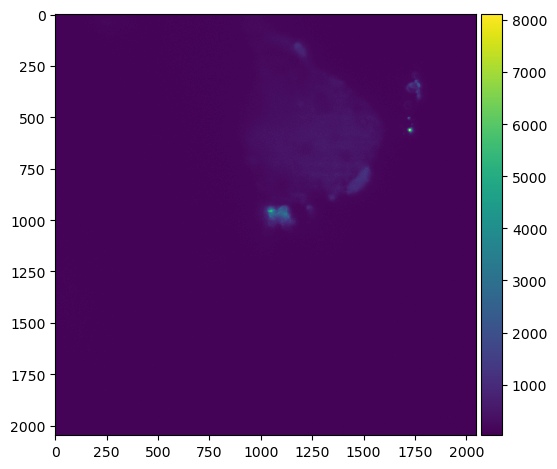

In [17]:
# check sample image
# read_path = '/media/chiron/Goku/Piyush/time lapse_071222/Acquisition/Sample2/Pos1/snap/BF/Timepoint1/Default/'
read_path = os.path.join(main_dir, poses[0], channels[0], timepoints[0])
listfiles = []
for img_files in sorted(os.listdir(read_path)):
        if img_files.endswith(".tif"):
            listfiles.append(img_files)
     
first_image = tiff.imread(os.path.join(read_path, listfiles[0]))
io.imshow(first_image[50])
first_image.shape

# Downsample and Save all Images

In [18]:
def read_zstack_v2(read_path): #reads image at read_path returning the downsampled image, v2 can take care of single images or image stacks
    listfiles =[]
    for img_files in sorted(os.listdir(read_path)):
        if img_files.endswith(".tif"):
            listfiles.append(img_files)

    # print(f'Reading: {os.path.join(read_path, listfiles[0])}')
    samp_img = tiff.imread(os.path.join(read_path, listfiles[0]))
    # print(samp_img.shape)

    if len(samp_img.shape)==2: #2 dimensional image, e.g. BF image or multiple z slice
        # print('single-stack image')
        stack_full = np.zeros((len(listfiles),samp_img.shape[0]//n,samp_img.shape[1]//n))#,np.uint16)
        if len(listfiles)==1: #as single file already read in samp_img
            img_downscaled = skimage.transform.downscale_local_mean(samp_img, (n, n))
            stack_full[0,:,:] = img_downscaled
            # print(f'Shape of ds image {stack_full.shape}')
        else:
            for i, val in enumerate(listfiles):
                # print(f'Reading: {os.path.join(read_path, val)}')
                img = tiff.imread(os.path.join(read_path, val))
                img_downscaled = skimage.transform.downscale_local_mean(img, (n, n)) #use a kernel of nxn, this will downscale by a factor of n in both x & y
                stack_full[i,:,:] = img_downscaled
            # print(f'Shape of ds image {stack_full.shape}')

    elif len(samp_img.shape)==3: #z stack
        # print('multi-stack image')
        stack_full = np.zeros((samp_img.shape[0],samp_img.shape[1]//n,samp_img.shape[2]//n))

        if len(listfiles)==1: #there is only one img file and read in samp
            img_downscaled = skimage.transform.downscale_local_mean(samp_img, (1, n, n)) #use a kernel of nxn, this will downscale by a factor of n in both x & y
            stack_full = img_downscaled
        else:
            print("Change looping sequence to process a folder with multiple 3d images")
            return
    else:
        print("Can't process images with >3dimensions")
        return    

# old way of converting to uint16
    # if stack_full.shape[0]==1: #single page image, e.g. BF image
    #     return((np.squeeze(stack_full, axis=0)).astype('uint16'))
    # else: #image zstack, multi-page tiff
    #     return(stack_full.astype('uint16'))

# new way: use skimage
    if stack_full.shape[0]==1: #single page image, e.g. BF image
        return(skimage.util.img_as_uint(skimage.exposure.rescale_intensity(np.squeeze(stack_full, axis=0))))
    else: #image zstack, multi-page tiff
        return(skimage.util.img_as_uint(skimage.exposure.rescale_intensity(stack_full)))

In [19]:
# def read_zstack(read_path): #reads image at read_path returning the downsampled image
#     listfiles =[]
#     for img_files in sorted(os.listdir(read_path)):
#         if img_files.endswith(".tif"):
#             listfiles.append(img_files)
#     stack_full = np.zeros((len(listfiles),first_image.shape[0]//n,first_image.shape[1]//n))#,np.uint16)
    
#     for i, val in enumerate(listfiles):
#         print(f'Reading: {read_path+val}')
#         img = tiff.imread(read_path+val)
#         img_downscaled = skimage.transform.downscale_local_mean(img, (n, n)) #use a kernel of nxn, this will downscale by a factor of n in both x & y
#         stack_full[i,:,:] = img_downscaled
#     print(f'Shape of image {stack_full.shape}')
#     if stack_full.shape[0]==1: #single page image, e.g. BF image
#         return(np.squeeze(stack_full, axis=0))
#     else: #image zstack, multi-page tiff
#         return(stack_full)

In [20]:
for pos in tqdm(poses, desc='poses'): 
    for channel in tqdm(channels, desc=' channel'):
        for tp in tqdm(timepoints, desc='timepoints'):
            read_path = os.path.join(main_dir, pos, channel, tp)
            save_name = os.path.split(main_dir)[-1]+'_'+tp+'_'+pos+'_'+os.path.split(channel)[-1]+'_ds.tif'
            # if 'BF'.casefold() in channel.casefold(): #check if its brightfield folder
            #     read_path = os.path.join(main_dir, pos, channel, tp)
            #     save_name = tp+'_'+pos+'_'+'BF'+'_ds.tif'
            # else:
            #     read_path = os.path.join(main_dir, pos, channel, tp)
            #     save_name = tp+'_'+pos+'_'+channel+'_ds.tif'
            # os.chdir(save_path)
            tiff.imwrite(os.path.join(save_loc, save_name), read_zstack_v2(read_path))

poses:   0%|          | 0/5 [00:00<?, ?it/s]
<tifffile.TiffFile 'Timepoint1_MMStack.ome.tif'> OME series contains invalid TiffData index
<tifffile.TiffFile 'Timepoint1_MMStack.ome.tif'> OME series contains invalid TiffData index
<tifffile.TiffFile 'Timepoint1_MMStack.ome.tif'> OME series contains invalid TiffData index
<tifffile.TiffFile 'Timepoint1_MMStack.ome.tif'> OME series contains invalid TiffData index
<tifffile.TiffFile 'Timepoint1_MMStack.ome.tif'> OME series contains invalid TiffData index
<tifffile.TiffFile 'Timepoint1_MMStack.ome.tif'> OME series contains invalid TiffData index
<tifffile.TiffFile 'Timepoint1_MMStack.ome.tif'> OME series contains invalid TiffData index
<tifffile.TiffFile 'Timepoint1_MMStack.ome.tif'> OME series contains invalid TiffData index
<tifffile.TiffFile 'Timepoint1_MMStack.ome.tif'> OME series contains invalid TiffData index
<tifffile.TiffFile 'Timepoint1_MMStack.ome.tif'> OME series contains invalid TiffData index
<tifffile.TiffFile 'Timepoint1_MMSt

ValueError: failed to read 8388608 bytes, got 20898

---

# Appendix

check different downscaling algorithms

In [ ]:
# from skimage.transform import rescale, resize, downscale_local_mean

# image = tiff.imread(dir+listfiles[250])


# image_rescaled = rescale(image, 0.25, anti_aliasing=False)
# image_resized = resize(image, (image.shape[0] // 4, image.shape[1] // 4),
#                        anti_aliasing=True)
# image_downscaled = downscale_local_mean(image, (4, 4))

# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

# ax = axes.ravel()

# ax[0].imshow(image, cmap='gray')
# ax[0].set_title("Original image")

# ax[1].imshow(image_rescaled, cmap='gray')
# ax[1].set_title("Rescaled image (aliasing)")

# ax[2].imshow(image_resized, cmap='gray')
# ax[2].set_title("Resized image (no aliasing)")

# ax[3].imshow(image_downscaled, cmap='gray')
# ax[3].set_title("Downscaled image (no aliasing)")

# ax[0].set_xlim(0, 512)
# ax[0].set_ylim(512, 0)
# plt.tight_layout()
# plt.show()
# io.imsave('./rescaled_alias.png', image_rescaled)
# io.imsave('./resized_no alias.png', image_resized)
# io.imsave('./downscaled_mean.png', image_downscaled)